In [1]:
import sys
sys.path.append('/Users/pc/Documents/stfu/classes/_ee292d/CrowdCounting-P2PNet')
import os
import random
import torch
from collections import OrderedDict
from torch.utils.data import Dataset, Subset, DataLoader
from easydict import EasyDict
from PIL import Image
from torchvision import transforms
from models.backbone import BackboneBase_VGG
from models.matcher import build_matcher_crowd
from models.p2pnet import P2PNet, SetCriterion_Crowd
import models.vgg_ as vgg
from crowd_datasets.SHHA.SHHA import random_crop
from engine import train_one_epoch, evaluate_crowd_no_overlap, vis
import util.misc as utils
from tqdm import tqdm

SEED = 10541 #0x292D
VIS_DIR = 'vis'

In [2]:
def seed_all(seed=SEED):
    random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
# need to load pretraining from elsewhere
class CustomVGGBackboneWrapper(BackboneBase_VGG):
    def __init__(self, name, return_interm_layers=True):
        if name == 'vgg16_bn':
            backbone = vgg.vgg16_bn()
        elif name == 'vgg16':
            backbone = vgg.vgg16()
        num_channels = 256
        super().__init__(backbone, num_channels, name, return_interm_layers)

In [4]:
def load_new_model(model_args, device, verbose=False,
                   pretrain_layers=['backbone', 'fpn', 'classification', 'regression'],
                   freeze_layers=[]):
    num_classes = 1

    backbone = CustomVGGBackboneWrapper(model_args.backbone)
    model = P2PNet(backbone, model_args.row, model_args.line)
    # load pretrained weights
    if len(pretrain_layers) > 0:
        checkpoint = torch.load('../CrowdCounting-P2PNet/weights/SHTechA.pth', map_location='cpu')
        valid = lambda s: s[:s.find('.')] in pretrain_layers
        valid_state = OrderedDict([(k,v) for k,v in checkpoint['model'].items() if valid(k)])
        missing, unexpected = model.load_state_dict(valid_state, strict=False)
        if verbose:
            print(f"pretrained weights loaded without the following keys:\n{'\n'.join(missing)}")
            if len(unexpected) > 0:
                print(f"WARNING: received unexpected keys:\n{'\n'.join(unexpected)}")
    for layer in freeze_layers:
        for param in tqdm(getattr(model, layer).parameters(), desc=layer):
            param.requires_grad = False


    weight_dict = {'loss_ce': 1, 'loss_points': model_args.point_loss_coef}
    losses = ['labels', 'points']
    matcher = build_matcher_crowd(model_args)
    criterion = SetCriterion_Crowd(num_classes, \
                                matcher=matcher, weight_dict=weight_dict, \
                                eos_coef=model_args.eos_coef, losses=losses)
    return model.to(device), criterion.to(device)

In [5]:
DEFAULT_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

TRAIN_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])
class GrapeDataset(Dataset):
    def __init__(self, root_path='labeled/', img_ext='.jpg', lbl_ext='_lbl.txt', \
                 transform=DEFAULT_TRANSFORM, train_transform=TRAIN_TRANSFORM, train=False, patch=False, flip=False):
        self.root = root_path + ('' if root_path[-1] == '/' else '/')
        self.instances = [f[:-len(lbl_ext)] for f in os.listdir(self.root)
                          if os.path.isfile(self.root+f) and f.endswith(lbl_ext)]
        self.img_ext = img_ext
        self.lbl_ext = lbl_ext
        self.trf = transform
        self.trn_trf = train_transform
        self.train = train
        self.patch = patch
        self.flip = flip
    
    def __len__(self):
        return len(self.instances)
    
    def _get_points(self, name):
        label_path = self.root + name + self.lbl_ext
        with open(label_path, 'r') as f:
            coords_list = f.readlines()
        coords = torch.tensor(tuple(tuple(map(float, line.split())) for line in coords_list))
        return coords
    
    def _load_image(self, name):
        img_path = self.root + name + self.img_ext
        img = Image.open(img_path)
        return img
    
    def __getitem__(self, i):
        # only support single-instance indexing
        img = self._load_image(self.instances[i]) # PIL image
        point = self._get_points(self.instances[i]) # tensor
        # perform val transforms on Image object
        if not (self.train and self.patch): # if not cropping, handle resizing
            # fix size of tensors (need to fix this)
            # HACK: only batch one example at a time
            width, height = img.size
            new_width = width // 128 * 128
            new_height = height // 128 * 128
            img = img.resize((new_width, new_height), Image.LANCZOS)
            point[:,0] *= new_width/width
            point[:,1] *= new_height/height
        # perform standard transforms
        if self.train and self.trn_trf is not None:
            img = self.trn_trf(img)
        elif self.trf is not None:
            img = self.trf(img)
        # additional transformation if training
        if self.train:
            # data augmentation -> random scale
            scale_range = [0.7, 1.3]
            min_size = min(img.shape[1:])
            scale = random.uniform(*scale_range)
            # scale the image and points
            if scale * min_size > 128:
                img = torch.nn.functional.upsample_bilinear(img.unsqueeze(0), scale_factor=scale).squeeze(0)
                point *= scale
            # random crop augumentation
            if self.patch:
                # generates a batch of images -> we just want one
                imgs, points = random_crop(img, point, num_patch=1)
                img, point = torch.tensor(imgs[0]), points[0]
            # random flipping
            if random.random() > 0.5 and self.flip:
                # random flip
                img = transforms.functional.hflip(img)
                for i, _ in enumerate(point):
                    point[:, 0] = 128 - point[:, 0]
            
        img = img.type(torch.float32)
        # pack up related infos
        img_id = torch.tensor(i, dtype=torch.int32, requires_grad=False)
        target = {
            'point': point,
            'image_id': img_id,
            'labels': torch.ones([point.shape[0]]).long()
        }
        return img, target

In [6]:
dl_kwargs = {
    # 'batch_size': 128,
    'num_workers': 0,
    'pin_memory': True,
    'collate_fn': utils.collate_fn
}
def get_subset_dataloaders(dset, subset_idx, k, bsz=128, dl_kwargs=dl_kwargs):
    val_idx = subset_idx[k]
    val_subset = Subset(dset, val_idx)
    val_dl = DataLoader(val_subset, batch_size=1, **dl_kwargs) # HACK
    train_idx = torch.cat((subset_idx[:k].flatten(), subset_idx[k+1:].flatten()))
    trn_subset = Subset(dset, train_idx)
    train_dl = DataLoader(trn_subset, shuffle=True, batch_size=bsz, **dl_kwargs)
    trn_evaldl = DataLoader(trn_subset, batch_size=1, **dl_kwargs)
    return train_dl, trn_evaldl, val_dl

In [7]:
hparams = EasyDict(
    lr_gen = 1e-4, # orig: 1e-4
    lr_backbone = 1e-5, # orig: 1e-5
    weight_decay = 1e-4, #orig: 1e-4
    epochs = 200,
    lr_drop = 1000,
    bsz = 64, # orig: 32
    clip_max_norm = 0.1, #orig: 0.1
    val_every = 10,
    pretrain_layers = ['backbone', 'fpn'],
    freeze_layers = []
)
model_args = EasyDict(
    # required to build inference model
    backbone = 'vgg16_bn', # name of the convolutional backbone to use
    pretrained = False,
    row = 1, # row number of anchor points
    line = 1, # line number of anchor points
    # required for model training
    point_loss_coef = 2e-4, # orig: 2e-4
    eos_coef = 0.5, #orig: 0.5 # Relative classification weight of the no-object class
    set_cost_class = 2, #orig: 1 # for matcher -- Class coefficient in the matching cost
    set_cost_point = .05 #orig: .05 # for matcher -- L1 point coefficient in the matching cost
)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)
base_dset = GrapeDataset(train=False, patch=False, flip=False)
K = 5
print(len(base_dset))
assert len(base_dset) % K == 0 # kfold splits must be exactly even

mps
200


In [8]:
seed_all()
folds = torch.randperm(len(base_dset)).reshape(K, -1)
# wipe vis directory for val outputs
for f in os.listdir(VIS_DIR):
    if f.endswith('jpg'):
        os.remove(f"{VIS_DIR}/{f}")
for k in range(K-1,K):
    print(f">>> FOLD {k+1}/{K} <<<")
    train_dl, trn_evaldl, val_dl = get_subset_dataloaders(base_dset, folds, k, bsz=hparams.bsz, dl_kwargs=dl_kwargs)
    model, criterion = load_new_model(model_args, device, pretrain_layers=hparams.pretrain_layers, freeze_layers=hparams.freeze_layers)
    opt_params = [
        {
            "params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad],
            "lr": hparams.lr_gen
        },
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": hparams.lr_backbone,
        },
    ]
    optimizer = torch.optim.Adam(opt_params)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, hparams.lr_drop)
    for attr in ['train', 'patch', 'flip']:
        base_dset.__setattr__(attr, True)
    for epoch in range(hparams.epochs):
        print(f"EPOCH {epoch+1}/{hparams.epochs}")
        stats = train_one_epoch(model, criterion, train_dl, optimizer, device, \
                                epoch, hparams.clip_max_norm)
        lr_scheduler.step()
        if epoch and (epoch+1) % hparams.val_every == 0:
            # HACK: disable and then re-enable training-time args for the dataset
            for attr in ['train', 'patch', 'flip']:
                base_dset.__setattr__(attr, False)
            # visualize final results only
            vis_dir = VIS_DIR if hparams.val_every + epoch >= hparams.epochs else None
            t_mae, t_mse = evaluate_crowd_no_overlap(model, trn_evaldl, device, vis_dir=vis_dir)
            print(f"trn: mae={t_mae}, mse={t_mse}")
            v_mae, v_mse = evaluate_crowd_no_overlap(model, val_dl, device, vis_dir=vis_dir)
            print(f"val: mae={v_mae}, mse={v_mse}")
            # reset stuff for training
            for attr in ['train', 'patch', 'flip']:
                base_dset.__setattr__(attr, True)
    print("val idxs:", sorted(folds[k].tolist()))
    # input('waiting for check >')


>>> FOLD 5/5 <<<


ZeroDivisionError: division by zero

## analysis

In [21]:
import inference as inf
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-deep')

In [12]:
gc = inf.GrapeCounter(device='mps')

In [16]:
for attr in ['train', 'patch', 'flip']:
    base_dset.__setattr__(attr, False)
# _, _, val_dl = get_subset_dataloaders(base_dset, folds, 4, bsz=hparams.bsz, dl_kwargs=dl_kwargs)
v_mae, v_mse = evaluate_crowd_no_overlap(gc.model, val_dl, device, vis_dir=VIS_DIR)
print(f"val: mae={v_mae}, mse={v_mse}")

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_29958/245802525.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_id = torch.tensor(i, dtype=torch.int32, requires_grad=False)


val: mae=7.85, mse=10.644247272588137


In [34]:
# idxs = []
ys = []
preds = []
for sample, target in val_dl:
    with torch.no_grad():
        outputs = gc.model(sample.to(gc.device))
        points = gc._get_points(outputs).cpu().numpy()
    # idxs.append(target[0]['image_id'].item())
    ys.append(len(target[0]['point']))
    preds.append(len(points))
ys = torch.tensor(ys)
preds = torch.tensor(preds)

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_29958/245802525.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_id = torch.tensor(i, dtype=torch.int32, requires_grad=False)


/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_29958/3611545113.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


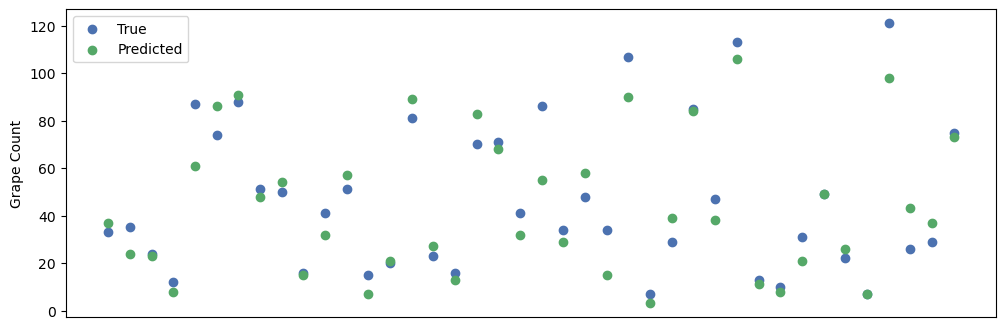

In [30]:
xr = torch.arange(len(preds))
order = torch.argsort(ys)
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(xr, ys[order], label='True')
ax.scatter(xr, preds[order], label='Predicted')
ax.legend()
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Grape Count')
fig.show()

/var/folders/cp/ps4v9yh52dj0wy2dnwf912cr0000gn/T/ipykernel_29958/1081490356.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


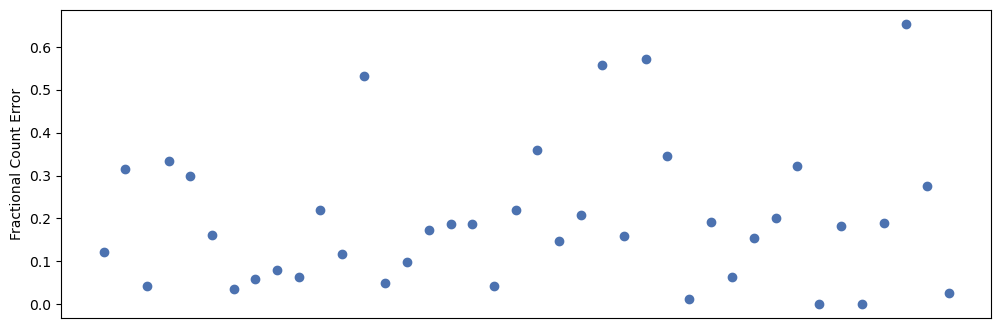

In [33]:
_ys = torch.tensor(ys)
_preds = torch.tensor(preds)
frac_diff = torch.abs(_ys - _preds) / _ys
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(xr, frac_diff)
ax.get_xaxis().set_visible(False)
ax.set_ylabel('Fractional Count Error')
fig.show()

In [36]:
print(os.listdir(VIS_DIR))

['180_gt_121_pred_98_pred.jpg', '57_gt_50_pred_42_pred.jpg', '30_gt_26_pred_43_pred.jpg', '150_gt_84_pred_95_pred.jpg', '34_gt_20_pred_15_pred.jpg', '53_gt_43_pred_46_pred.jpg', '78_gt_78_pred_76_pred.jpg', '146_gt_32_pred_36_pred.jpg', '55_gt_9_pred_8_pred.jpg', '163_gt_16_pred_11_pred.jpg', '153_gt_47_pred_38_pred.jpg', '191_gt_78_pred_43_pred.jpg', '7_gt_47_pred_51_pred.jpg', '107_gt_86_pred_45_pred.jpg', '52_gt_28_pred_30_pred.jpg', '6_gt_17_pred_14_pred.jpg', '130_gt_44_pred_44_pred.jpg', '16_gt_35_pred_24_pred.jpg', '145_gt_48_pred_57_pred.jpg', '182_gt_60_pred_70_pred.jpg', '128_gt_39_pred_38_pred.jpg', '83_gt_21_pred_12_pred.jpg', '174_gt_24_pred_22_pred.jpg', '190_gt_28_pred_8_pred.jpg', '79_gt_38_pred_39_pred.jpg', '10_gt_49_pred_41_pred.jpg', '192_gt_79_pred_82_pred.jpg', '148_gt_33_pred_27_pred.jpg', '184_gt_30_pred_28_pred.jpg', '147_gt_60_pred_45_pred.jpg', '176_gt_26_pred_26_pred.jpg', '158_gt_68_pred_52_pred.jpg', '39_gt_73_pred_71_pred.jpg', '119_gt_43_pred_24_pred.jpg

In [38]:
val_idxs = sorted(folds[k].tolist())
for f in os.listdir(VIS_DIR):
    f_idx = int(f[:f.find('_')])
    if not (f_idx in val_idxs):
        os.remove(f"{VIS_DIR}/{f}")

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


# fixing crops

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [39]:
path = 'cropped/'
images = [f for f in os.listdir(path)
          if os.path.isfile(path+f) and f.endswith('.jpg')]
THRESH = 5 # need more than THRESH nonzero values to be considered valid
BLACK_THRESH = 100
MIN_IMG_DIM = 128

# finds the first index of 1D array x that surpasses the threshold
find_first = lambda x: (x > THRESH).argmax()
for img_name in images:
    img = cv2.imread(path+img_name)
    nonblack_mask = (img > BLACK_THRESH)
    img_1ch = nonblack_mask.any(axis=2).astype(int) # flatten channels
    first_good_x = find_first(img_1ch.sum(axis=0))
    first_good_y = find_first(img_1ch.sum(axis=1))
    # crop
    cropped_img = img
    if first_good_x:
        cropped_img = cropped_img[:, first_good_x:-first_good_x]
    if first_good_y:
        cropped_img = cropped_img[first_good_y:-first_good_y]
    roi = cropped_img
    min_dim = min(roi.shape[0], roi.shape[1])
    scale = max(1, MIN_IMG_DIM/min_dim)
    scale_up = lambda l: int(np.ceil(scale*l))
    roi_out = cv2.resize(roi, (scale_up(roi.shape[1]), scale_up(roi.shape[0])))
    # fix coordinates
    # label_path = path+img_name[:-len("anno.jpg")]+"lbl.txt"
    # with open(label_path, 'r') as f:
    #     coords_list = f.readlines()
    #     coords = [tuple(map(int, line.split())) for line in coords_list]
    #     fixed_coords = [(scale_up(x-first_good_x), scale_up(y-first_good_y)) for (x,y) in coords]
    # label_str = '\n'.join([f"{x} {y}" for (x,y) in fixed_coords])
    # overwrite files
    cv2.imwrite(path+img_name, roi_out)
    # with open(label_path, 'w') as f:
    #     f.write(label_str)